In [54]:
%pip install qiskit
%pip install qiskit[visualization]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Theoretical Bloch vector result: [0.9428090415820635, 0, 0.3333333333333333]
Resulting Bloch vector: [0.94482421875, 0.009033203125, 0.35205078125]


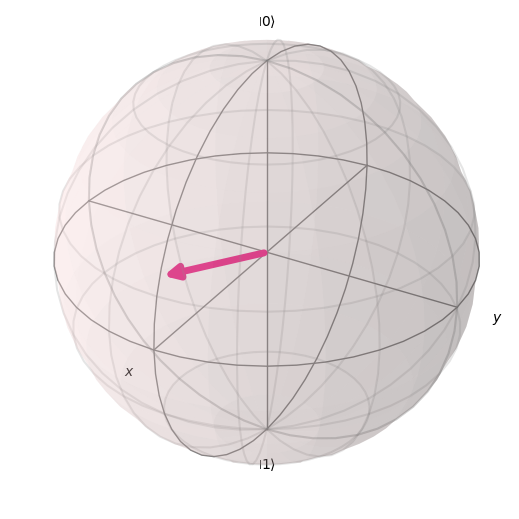

In [69]:
from math import sqrt
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_bloch_vector


def quantum_state_tomography(alpha, beta):
    qc: QuantumCircuit = QuantumCircuit(1, 1)
    target_state_vector = [alpha, beta]
    qc.initialize(target_state_vector, 0)

    measure_x = QuantumCircuit(1, 1)
    measure_x.h(0)
    measure_x.measure(0, 0)

    measure_y = QuantumCircuit(1, 1)
    measure_y.sdg(0)
    measure_y.h(0)
    measure_y.measure(0, 0)

    measure_z = QuantumCircuit(1, 1)
    measure_z.measure(0, 0)

    qc_x = qc.compose(measure_x)
    qc_y = qc.compose(measure_y)
    qc_z = qc.compose(measure_z)

    state_vector_sampler = StatevectorSampler()
    shots = 8192
    results_x = state_vector_sampler.run([qc_x], shots=shots).result()
    results_y = state_vector_sampler.run([qc_y], shots=shots).result()
    results_z = state_vector_sampler.run([qc_z], shots=shots).result()

    counts_x = results_x[0].data.c.get_counts()
    x = abs(counts_x.get('0', 0) - counts_x.get('1', 0)) / shots

    counts_y = results_y[0].data.c.get_counts()
    y = abs(counts_y.get('0', 0) - counts_y.get('1', 0)) / shots

    counts_z = results_z[0].data.c.get_counts()
    z = abs(counts_z.get('0', 0) - counts_z.get('1', 0)) / shots

    return [x, y, z]

alpha = sqrt(2 / 3)
beta = sqrt(1 / 3)
bloch_vector = quantum_state_tomography(alpha, beta)
print("Theoretical Bloch vector result:", [(2 * sqrt(2)) / 3, 0, 1 / 3])
print("Resulting Bloch vector:", bloch_vector)
plot_bloch_vector(bloch_vector)


Prerequisites for IBM Quantum Platform usage.

In [55]:
%pip install qiskit
%pip install qiskit[visualization]
%pip install qiskit-ibm-runtime

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Save account to Qiskit, according to configuration file 'ibm_quantum_config.json'.

In [77]:
import os
import sys
import json
from qiskit_ibm_runtime import QiskitRuntimeService


if not os.path.exists("ibm_quantum_config.json"):
    print("Please create a file named 'ibm_quantum_config.json' with your IBM Quantum API token.")
    sys.exit(1)

with open("ibm_quantum_config.json", "r") as config_file:
    config = json.load(config_file)
    print("Configuration loaded successfully.")

QiskitRuntimeService.save_account(
    channel=config["channel"],
    token=config["token"],
    overwrite=True
)

print("Account saved successfully.")

Configuration loaded successfully.
Account saved successfully.


Load account from Qiskit.

In [71]:
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService()
print("Account loaded successfully!")

qpus = service.backends(operational=True, simulator=False)
print(f"Available QPUs: {qpus}")

least_busy_qpu = service.least_busy(operational=True, simulator=False)
print(f"Least busy QPU: {least_busy_qpu.name}")

least_busy_qpu_n_qubits = least_busy_qpu.configuration().n_qubits
print(f"Least busy QPU number of qubits: {least_busy_qpu_n_qubits}")

Account loaded successfully!
Available QPUs: [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]
Least busy QPU: ibm_brisbane
Least busy QPU number of qubits: 127


In [17]:
from math import sqrt
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_vector
from qiskit_ibm_runtime import QiskitRuntimeService


def quantum_state_tomography(alpha, beta):
    qc: QuantumCircuit = QuantumCircuit(1, 1)
    target_state_vector = [alpha, beta]
    qc.initialize(target_state_vector, 0)

    measure_x = QuantumCircuit(1, 1)
    measure_x.h(0)
    measure_x.measure(0, 0)

    measure_y = QuantumCircuit(1, 1)
    measure_y.sdg(0)
    measure_y.h(0)
    measure_y.measure(0, 0)

    measure_z = QuantumCircuit(1, 1)
    measure_z.measure(0, 0)

    qc_x = qc.compose(measure_x)
    qc_y = qc.compose(measure_y)
    qc_z = qc.compose(measure_z)

    service = QiskitRuntimeService()
    print("Account loaded successfully!")

    qpus = service.backends(operational=True, simulator=False)
    print(f"Available QPUs: {qpus}")

    qpu = service.least_busy(operational=True, simulator=False)
    print(f"Using QPU: {qpu.name}")

    qc_x_transpiled = transpile(qc_x, qpu)
    qc_y_transpiled = transpile(qc_y, qpu)
    qc_z_transpiled = transpile(qc_z, qpu)

    shots = 8192
    job_qc_x = qpu.run(qc_x_transpiled, shots=shots)
    job_qc_y = qpu.run(qc_y_transpiled, shots=shots)
    job_qc_z = qpu.run(qc_z_transpiled, shots=shots)

    counts_x = job_qc_x.result().get_counts()
    x = abs(counts_x.get('0', 0) - counts_x.get('1', 0)) / shots

    counts_y = job_qc_y.result().get_counts()
    y = abs(counts_y.get('0', 0) - counts_y.get('1', 0)) / shots

    counts_z = job_qc_z.result().get_counts()
    z = abs(counts_z.get('0', 0) - counts_z.get('1', 0)) / shots

    return [x, y, z]

alpha = sqrt(2 / 3)
beta = sqrt(1 / 3)

bloch_vector = quantum_state_tomography(alpha, beta)
print("Theoretical Bloch vector result:", [(2 * sqrt(2)) / 3, 0, 1 / 3])
print("Resulting Bloch vector:", bloch_vector)

plot_bloch_vector(bloch_vector)

Account loaded successfully!
Available QPUs: [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]
Using QPU: ibm_brisbane


/var/folders/wj/lz20hs3j6wb72blknj2l_ptr0000gn/T/ipykernel_63733/2546822907.py:40: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job_qc_x = qpu.run(qc_x_transpiled, shots=shots)
/var/folders/wj/lz20hs3j6wb72blknj2l_ptr0000gn/T/ipykernel_63733/2546822907.py:41: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job_qc_y = qpu.run(qc_y_transpiled, shots=shots)
/var/folders/wj/lz20hs3j6wb72blknj2l_ptr0000gn/T/ipykernel_63733/2546822907.py:42: DeprecationWarning: backend.run() and related sessi

KeyboardInterrupt: 